In [6]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
alpha = 1./1000.
beta = 8.0/3.0
sigma = 10.

T = 1.
omega = 1./T

def calc_rho(t, omega):
  return 60 + 30*np.tanh(omega*(t - 100))

def calc_ddt(t, xv_flat, alpha, beta, sigma, omega):
  xv = xv_flat.reshape(-1, 3)

  rho = calc_rho(t, omega)
  x, y, z = xv[:,0], xv[:,1], xv[:,2]
  dx = sigma*(y - x)
  dy = -(x + alpha*np.pow(x,3)) + rho*x - y
  dz = x*y - beta*z

  ddt_flat = np.column_stack([dx, dy, dz]).ravel()

  return ddt_flat

In [67]:
# Parameters
t = 0.0
dt = 1.0 / 64
tmax = 1000.0
r = 10.0 * dt
N = 5000

# Initial conditions
rho = calc_rho(0, omega)
x = (rho - 1) * np.ones(N)
y = 2.0 * np.random.rand(N) - 1.0
z = 2.0 * np.random.rand(N) - 1.0

# Combine x,y,z into one array of shape (N, 3)
xv = np.column_stack([x, y, z])

# Pre-allocate arrays for storage
nt = int(tmax / dt) + 1
xs   = np.zeros(nt)         # mean of x-component
xr   = np.zeros((50, nt))   # snapshot of first 50 x-values
xm   = np.zeros((3, nt))    # max of each column in xv
xstd = np.zeros(nt)         # std of x-component

# Fill initial values
j = 0
xs[j]   = np.mean(xv[:, 0])
xr[:, j] = xv[:50, 0]
xm[:, j] = np.max(xv, axis=0)
xstd[j]  = np.std(xv[:, 0])

# Time-integration loop
while t < tmax:
  # Single-step ODE from t to t+dt using solve_ivp with method=RK45
  sol = solve_ivp(calc_ddt, [t, t + dt], xv.flatten(),
                  method='RK45', t_eval=[t + dt],
                  args=(alpha, beta, sigma, omega))

  # Extract the final state, reshape it back to (N,3)
  xv = sol.y[:, -1].reshape((N, 3))
  t += dt

  # Add the Gaussian noise
  xv += r * np.random.randn(*xv.shape)

  # Store statistics
  j += 1
  xs[j]   = np.mean(xv[:, 0])
  xr[:, j] = xv[:50, 0]
  xm[:, j] = np.max(xv, axis=0)
  xstd[j]  = np.std(xv[:, 0])

/var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/ipykernel_51530/1077764080.py:7: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(rhos[ind], xs[ind], 1)   # slope & intercept


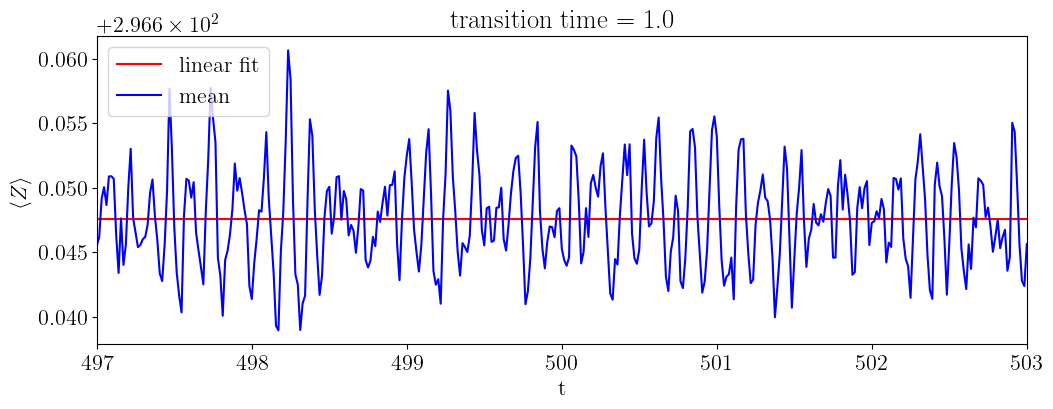

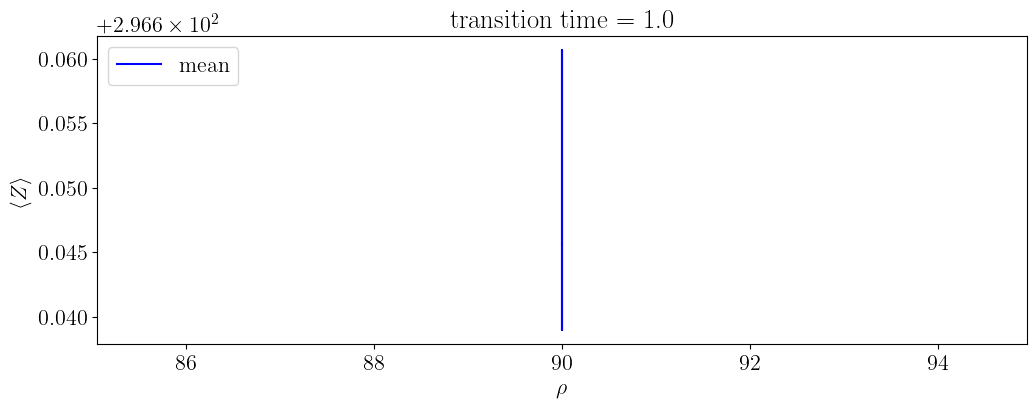

In [68]:
# 1) Create time array and compute rhos
ts = np.arange(0, tmax + dt, dt)
rhos = calc_rho(ts, omega)

# 2) Linear fit for t >= 200
ind = np.where(ts >= 200)
p = np.polyfit(rhos[ind], xs[ind], 1)   # slope & intercept
xfit = np.polyval(p, rhos)             # Evaluate the fit over all times

# 4) Load quasiequilibrium data (rho_r, xbar) from a .mat file
#data = loadmat('cublor-av0.mat')  # file must contain 'rho_r' and 'xbar'
#rho_r = data['rho_r'].ravel()
#xbar  = data['xbar'].ravel()

# Interpolate xbar to our rhos
#xqe = np.interp(rhos, rho_r, xbar)

# 5) Restrict to region around tmax/2 ± 3*period
tmid = tmax/2
ind2 = np.where((ts >= tmid - 3*T) & (ts <= tmid + 3*T))[0]

# 6) Plot vs time
plt.figure()
plt.plot(ts[ind2], xfit[ind2], 'r', label='linear fit')
plt.plot(ts[ind2], xs[ind2],   'b', label='mean')
#plt.plot(ts[ind2], xqe[ind2], '--k', label='quasiequilibrium')
plt.title(f"transition time = {T}")
plt.xlabel("t")
plt.ylabel(r"$\langle Z\rangle$")
plt.legend(loc='upper left')
plt.xlim([ts[ind2[0]], ts[ind2[-1]]])

# 7) Plot vs rho
plt.figure()
#plt.plot(rhos[ind2], xfit[ind2], 'r', label='linear fit')
plt.plot(rhos[ind2], xs[ind2],   'b', label='mean')
#plt.plot(rhos[ind2], xqe[ind2], '--k', label='quasiequilibrium')
plt.title(f"transition time = {T}")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\langle Z\rangle$")
plt.legend(loc='upper left')
#plt.savefig(f"cublort-fit-{period}-rho.png")